# Demonstration of Combining Two Defences

## Imports and CIFAR-10 loading

In [1]:
# Requirements for running everything
import torch

# File containing all the required training methods
import defences.cifar10_library as cifar10_library

# For testing
import utils.clean_test as clean_test

# Contains the data loadders
import utils.dataloaders as dataloaders

# For printing outcomes
# import utils.printing as printing

# Example printing, but I removed it to simplify results
# for epsilon in epsilons:
#     printing.print_attack(
#         model,
#         testSetLoader,
#         "FGSM",
#         attacks["FGSM"],
#         epsilon=epsilon,
#     )

Notebook will use PyTorch Device: CUDA
Notebook will use PyTorch Device: CUDA
Notebook will use PyTorch Device: CUDA
Notebook will use PyTorch Device: CUDA
Notebook will use PyTorch Device: CUDA


## Load the dataset

In [2]:
DATA_ROOT = "./datasets/CIFAR10"

trainSetLoader, _, testSetLoader = dataloaders.get_CIFAR10_data_loaders(
    DATA_ROOT,
    trainSetSize=50000,
    validationSetSize=0,
    batchSize=128,
)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


## Save path

In [3]:
SAVE_LOAD_ROOT = "./data/cifar10"

## Only evaluate against PGD adversaries

In [4]:
# A possible attacks array (for nice printing):
import attacks.pgd as pgd
import utils.attacking as attacking

attacks = {}

attacks["PGD"] = pgd.pgd_attack

## Training Phase: Jacobian Regularizared PG+$CW_2$ Adversarially Trained Model (i.e. 2-Attack Adversarial Training)

In [5]:
# Pass none since if there is no attack function specified, will use CW2 instead
framework_model = cifar10_library.framework_training(
    trainSetLoader,
    attack_function1=attacks["PGD"],
    attack_function2=None,
    load_if_available=True,
    load_path=SAVE_LOAD_ROOT + "/cifar10_framework",
    epsilon1=(8 / 255),
    alpha=(2 / 255),
    iterations=7,
    steps=15,
    c=0.15,
)

Found already trained model...
... loaded!


In [6]:
# Test the model
clean_test.test_trained_model(framework_model, testSetLoader)

Testing the model...


Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 86.03%


### Printing

/tmp/ipykernel_432/2064583748.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


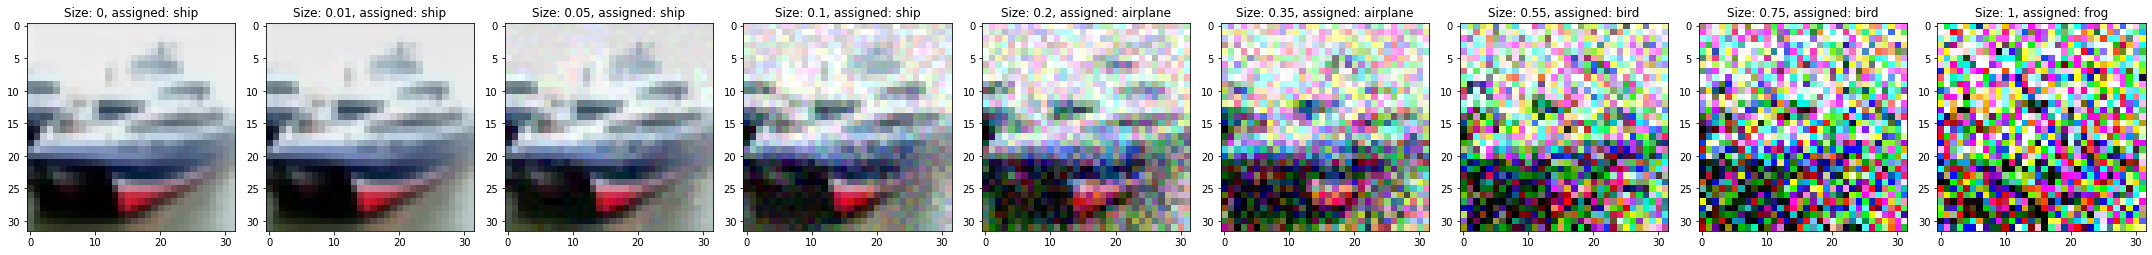

In [7]:
import matplotlib.pyplot as plt

# Labels
label_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

# Several values to use for the epsilons
original_image, label = testSetLoader.dataset[1]
label = torch.tensor([label])
original_image = original_image.reshape(1, 3, 32, 32)
epsilons = [0, 0.01, 0.05, 0.1, 0.2, 0.35, 0.55, 0.75, 1]

# Save perturbed images
perturbed_images = []

# For plotting
fig, axs = plt.subplots(1, len(epsilons))

for index in range(len(epsilons)):
    
    # Calculate perturbation
    epsilon = epsilons[index]
    perturbed_image = pgd.pgd_attack(
        original_image,
        label,
        framework_model,
        torch.nn.CrossEntropyLoss(),
        epsilon=epsilon,
        alpha=(2 / 255),
        iterations=7,
        scale=True,
    )

    # Classify
    logits = framework_model(perturbed_image)
    _, prediction = torch.max(logits, 1)

    # Add to list
    perturbed_images.append(perturbed_image.detach().cpu().numpy())

    # Prepare for printing
    perturbed_image = perturbed_image.detach().cpu().numpy().reshape(3, 32, 32)
    perturbed_image = perturbed_image.transpose(1, 2, 0)
    
    # Assigned label
    label_name = label_names[prediction.detach().cpu().numpy()[0]]

    # Print
    axs[index].set_title(f"Size: {epsilon}, assigned: {label_name}")
    axs[index].imshow(perturbed_image)

fig.set_size_inches(30, 35)
fig.tight_layout()
fig.show()

### Evaluation

#### PGD

In [8]:
# Several values to use for the epsilons
epsilons = [0, 0.01, 0.05, 0.1, 0.2, 0.35, 0.55, 0.75, 1]
robustness = []

for epsilon in epsilons:
    robustness.append(
        attacking.attack_model(
            framework_model,
            testSetLoader,
            "PGD",
            attacks["PGD"],
            epsilon=epsilon,
            alpha=(2 / 255),
            iterations=7,
        ) / 100
    )

Testing the model under PGD Attack using epsilon = 0, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 86.03%
------------------------------------

Testing the model under PGD Attack using epsilon = 0.01, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 73.29%
------------------------------------

Testing the model under PGD Attack using epsilon = 0.05, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 33.75%
------------------------------------

Testing the model under PGD Attack using epsilon = 0.1, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 24.18%
------------------------------------

Testing the model under PGD Attack using epsilon = 0.2, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 11.51%
------------------------------------

Testing the model under PGD Attack using epsilon = 0.35, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 2.56%
------------------------------------

Testing the model under PGD Attack using epsilon = 0.55, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 0.5%
------------------------------------

Testing the model under PGD Attack using epsilon = 0.75, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 0.25%
------------------------------------

Testing the model under PGD Attack using epsilon = 1, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 0.19%
------------------------------------



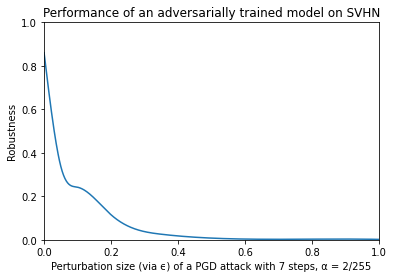

In [9]:
# Plot the results of the attack
import numpy as np
import numpy as np
from scipy.interpolate import make_interp_spline
import matplotlib.pyplot as plt

epsilons = np.asarray(epsilons)
robustness = np.asarray(robustness)
X_Y_Spline = make_interp_spline(epsilons, robustness)
 
# Returns evenly spaced numbers
# over a specified interval.
X = np.linspace(epsilons.min(), epsilons.max(), 500)
Y= X_Y_Spline(X)
 
# Plotting the Graph
plt.plot(X, Y)
plt.title("Performance of an adversarially trained model on SVHN")
plt.xlabel("Perturbation size (via ϵ) of a PGD attack with 7 steps, α = 2/255")
plt.ylabel("Robustness")
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.show()

## Detection Phase: PCA-based Detection

In [10]:
import numpy as np
import torch.nn as nn
from sklearn.decomposition import PCA
from tqdm.notebook import tnrange, tqdm

# Define the `device` PyTorch will be running on, please hope it is CUDA
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Notebook will use PyTorch Device: " + device.upper())

loss_function = nn.CrossEntropyLoss()

# Copy the SVHN data and then fit using PCA
# First convert to numpy arrays (and make it float)
numpyTrainingData = trainSetLoader.dataset.data.astype("float32")
# Note you also need to reshape the input data for your sanity
reshapedNumpyTrainingData = numpyTrainingData.reshape(
    (len(numpyTrainingData), 32 * 32 * 3)
)

# Then perform PCA on training data to get principal components
# Note it should reflect dimension of image, i.e. 28 * 28
pca = PCA(n_components=32 * 32 * 3).fit(reshapedNumpyTrainingData)

Notebook will use PyTorch Device: CUDA


#### PGD Data

In [11]:
data = [perturbed_images[-2]]
data = np.asarray(data)
numpyTestData = data.astype("float32")
reshapedNumpyTestData = numpyTestData.reshape((len(numpyTestData), 32 * 32 * 3))

# Original predictions on data
predictions_base = np.zeros((len(numpyTestData), ))

for index in range(len(numpyTestData)):
    testTensor = torch.from_numpy(np.reshape(numpyTestData[index], (1, 3, 32, 32))).to(
        device
    )

    with torch.no_grad():
        logits = framework_model(testTensor).detach().cpu().numpy()

    predictions_base[index] = np.argmax(logits)

# Transform clean data along principal components
transformedTestData = pca.transform(reshapedNumpyTestData)

# Decides how many of the least significant coefficients (of components) to perturb
num_components = 1000

# How many trials to run
num_trials = 1

# Track results
result = np.zeros(len(numpyTestData), dtype=int)

# Actual attempts
for trial in range(num_trials):
    random_noise = np.random.standard_normal(size=num_components)

    # Copy the data
    transformedTestDataNoisy = np.copy(transformedTestData)

    # Update the components with the right data
    for index in range(len(numpyTestData)):
        transformedTestDataNoisy[index][(32 * 32 * 3 - num_components):] += (
            10 * random_noise
        )

    # Now calculate the inverse using PCA and the noise
    inverseTestDataNoisy = pca.inverse_transform(transformedTestDataNoisy)

    # Reshape into image
    testDataNoisy = np.reshape(
        inverseTestDataNoisy, (len(numpyTestData), 3, 32, 32))

    # Modified predictions on data
    predictions_modified = np.zeros((len(numpyTestData), ))

    for index in range(len(testDataNoisy)):
        testTensor = torch.from_numpy(
            np.reshape(testDataNoisy[index], (1, 3, 32, 32))
        ).to(device)

        with torch.no_grad():
            logits = framework_model(testTensor).detach().cpu().numpy()

        predictions_modified[index] = np.argmax(logits)

    check = np.not_equal(predictions_modified, predictions_base)
    result = np.logical_or(check, result)

# Printing
if np.sum(result) > 0:
    print("Detected input as adversarial example")
else:
    print("Input is benign")


Detected input as adversarial example


## Detection Phase: Mahalanobis-based Detection

Please see in the **defences/mahalanobis_detector/** folder how to run the Mahalanobis-based Detection component, as it has a separate procedure.